In [1]:
# from os import sched_get_priority_max

import math
import numpy as np
import pandas as pd
import seaborn as sns
import pickle
from collections import Counter
from imblearn.over_sampling import SMOTE
import sklearn
from matplotlib import pyplot
from scipy.stats import shapiro
from sklearn import model_selection
import matplotlib.pyplot as plt
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import classification_report, accuracy_score, plot_confusion_matrix
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split, GridSearchCV

In [2]:
def upload_data():
    ######  Data understanding and cleaning  #####
    dfaux = pd.read_csv('Proj1_Dataset.csv', sep=',')  # open the file
    print("SHAPE: ", dfaux.shape)  # check the data shape
    print("INFO:")
    print(dfaux.info())  # see the information regarding the data on the Dataframe
    dfaux.drop_duplicates(inplace=True)  # see if it has duplicates and removes them
    print("\nSHAPE: ", dfaux.shape)
    print("NUMBER OF NULL VALUES: \n", dfaux.isnull().sum())  # shows how many null values each column has
    return dfaux

In [3]:
def create_subset(df):
    df_subset_aux = df.loc[:, 'S1Temp':'Persons'].copy()  # creates data subset without first two columns
    df_subset_aux.interpolate(inplace=True)  # Finds null values and substitutes them with average of next two
    print("DATA INFORMATION: \n", df_subset_aux.head(5))
    # print(df[(df["CO2"].isnull())].index)
    return df_subset_aux

In [4]:


def remove_outliers(df_subset):
    # helps to understand the data by giving information about frequency of numbers, max and min
    print("FREQUENCY OF DATA:\n", df_subset['Persons'].value_counts().head(20))  # from here we can take
    # that data is not well-balanced
    print("max: ", df_subset['PIR2'].max())
    print("min: ", df_subset['PIR2'].min())

    # Sees and takes out the outliers
    k = 6
    for i in range(9):
        
        df_subset[features[i]].plot(kind="box");
        plt.show()
        plt.close()
        
        standard_deviation = df_subset[features[i]].std()  # calculates standard deviation of each feature
        mean = df_subset[features[i]].mean()  # calculates mean of each feature
        Outlier_max = k * standard_deviation  # calculates max value that is considered an outlier of each feature
        # print(mean)
        # print(standard_deviation)
        indexLow = df_subset[(df_subset[features[i]] <= (mean - Outlier_max)) | (df_subset[features[i]] >=
                    (mean + Outlier_max))].index  # Trys to find outliers and stores their index
        # print("------ ", i)
        # print(indexLow)
        df_subset.loc[indexLow, features[i]] = np.nan  # sets outliers value to null
        # print("DATA INFORMATION: \n", df_subset.head(3760))

    df_subset.interpolate(inplace=True)  # Finds null values and substitutes them with average of next two

In [5]:
def scatter_plot_comparison(df_subset):
    sns.relplot(data=df_subset, x='PIR1', y='S1Light', hue='Persons', size='CO2')
    plt.show()
    plt.close()
    # print("DATA INFORMATION: \n", df_subset.head(3760))



In [6]:
def multiclass_problem(neurons, X_train, y_train, X_test, y_test):
    # Testa hyperparametros para o training set normal, o melhor foi (activation='relu', hidden_layer_sizes=(6, 4,
    # 4), learning_rate='adaptive', max_iter=2000, random_state=4, solver='sgd'), o 2 melhor é {'activation': 'relu',
    # 'hidden_layer_sizes': (6, 3), 'learning_rate': 'constant', 'max_iter': 2000, 'random_state': 4, 'solver': 'sgd'}

    # change hyperparameters below and run the code to test which ones give the best results
    parameters = {'hidden_layer_sizes': [(neurons+1,3,3), (neurons+1,3,2), (neurons+1,4,4),
                                         (neurons+1,4,2), (neurons+1,5,5), (neurons+1,4,3)],
                  'max_iter': [1000, 2000],
                  'random_state': [4],
                  'activation': ['logistic', 'relu', 'tanh'],
                  'solver': ['sgd'],
                  'learning_rate': ['constant', 'adaptive']
                  }

    # lbfgs doesn't converge
    clf = GridSearchCV(MLPClassifier(), parameters, n_jobs=-1, scoring='f1_micro')  # does cross validation with the
    #parameters given before to check the best ones

    clf.fit(X_train, y_train)  # does gridsearch on the training data to create the best model
    print('Score:',clf.score(X_train, y_train))
    print('Best Params:',clf.best_params_)  # best parameters achieved by the gridsearch

    '''
    # Testa hyperparametros para o training set ao usar o método de sampling SMOTE to balance the data

    parameters1 = {
        'hidden_layer_sizes': [(15, 9), (15,10), (15,11),(15,9,9)],
        'max_iter': [1000],
        'random_state': [4],
        'activation': ['logistic'], 'solver': ['sgd'],
        'learning_rate': ['constant', 'adaptive']}

    sm = SMOTE(random_state=42)  # creates the smote model
    
    X_res, y_res = sm.fit_resample(X_train, y_train)  # resamples the data to make it balanced
    
    print('Counter:',Counter(y_res))
    clf = GridSearchCV(MLPClassifier(), parameters1, n_jobs=-1, scoring='f1_micro')
    clf.fit(X_res, y_res)
    print('Score:',clf.score(X_res, y_res))
    print('Best Params:',clf.best_params_)

    
    # Tests the best model achieved with the SMOTE data
    print("SMOTE VALUES: \n")
    clf = MLPClassifier(activation='logistic', hidden_layer_sizes=(15, 9), learning_rate='adaptive', max_iter=1000,
                        random_state=4, solver='sgd')
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    scores(clf, y_pred)
    '''

    # Tests the best model achieved with the unbalanced normal data
    print("NORMAL VALUES:")
    clf = MLPClassifier(activation='relu', hidden_layer_sizes=(6, 4, 4), learning_rate='adaptive', max_iter=2000,
                        random_state=4, solver='sgd')
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    scores_multi(clf, y_pred)

    # save NN model to disk
    filename = 'finalized_model.sav'
    pickle.dump(clf, open(filename, 'wb'))



In [7]:

def scores_multi(clf, y_pred):
    print(clf.score(X_train, y_train))
    print('Accuracy: {:.2f}'.format(accuracy_score(y_test, y_pred)))
    fig = plot_confusion_matrix(clf, X_test, y_test, display_labels=clf.classes_)
    fig.figure_.suptitle("Confusion Matrix for Multiclass Classification")
    plt.show()
    plt.close()
    print("MULTI-CLASS PROBLEM SCORES: ")
    print(classification_report(y_test, y_pred))



In [8]:

def binary_problem(neurons, X_train, y_train, X_test, y_test):
    # Testa hyperparametros para o training set normal, o melhor foi {'activation': 'relu', 'hidden_layer_sizes': (6,
    # 4), 'learning_rate': 'constant', 'max_iter': 1000, 'random_state': 4, 'solver': 'sgd'}

    # Testa hyperparametros para o training set
    parameters = {'hidden_layer_sizes': [(neurons-1,5,4), (neurons-1,5,2), (neurons-1,4, 4),
                                         (neurons-1,4,3), (neurons-1,4,2), (neurons,4,4)],
                  'max_iter': [1000, 2000],
                  'random_state': [4],
                  'activation': ['logistic', 'relu'], 'solver': ['sgd'],
                  'learning_rate': ['constant', 'adaptive']}

    # lbfgs doesn't converge; best results with just one hidden layer
    clf = GridSearchCV(MLPClassifier(), parameters, n_jobs=-1, scoring='f1_micro')

    clf.fit(X_train, y_train)
    print('Score:',clf.score(X_train, y_train))
    print('Best Params:',clf.best_params_)

    print("NORMAL VALUES:")
    clf = MLPClassifier(activation='relu', hidden_layer_sizes=(6, 4, 4), learning_rate='constant', max_iter=1000,
                        random_state=4, solver='sgd')
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    scores_bin(clf, y_pred)


In [9]:


def scores_bin(clf, y_pred):
    print(clf.score(X_train, y_train))
    print('Accuracy: {:.2f}'.format(accuracy_score(y_test, y_pred)))
    fig = plot_confusion_matrix(clf, X_test, y_test, display_labels=clf.classes_)
    fig.figure_.suptitle("Confusion Matrix for Binary Classification")
    plt.show()
    plt.close()
    print("BINARY PROBLEM SCORES: ")
    print(classification_report(y_test, y_pred))



In [10]:

######  Data understanding and cleaning  #####
df = upload_data()  # reads the data from the file

# Transforms Date and time data to correct form
df['Date'] = pd.to_datetime(df['Date'], dayfirst=True)
df['Time'] = pd.to_datetime(df['Time'])
df['Time'] = pd.to_datetime(df['Time'], format='%H:%M').dt.time

SHAPE:  (10129, 12)
INFO:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10129 entries, 0 to 10128
Data columns (total 12 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Date     10129 non-null  object 
 1   Time     10129 non-null  object 
 2   S1Temp   10128 non-null  float64
 3   S2Temp   10127 non-null  float64
 4   S3Temp   10129 non-null  float64
 5   S1Light  10129 non-null  int64  
 6   S2Light  10129 non-null  int64  
 7   S3Light  10129 non-null  int64  
 8   CO2      10128 non-null  float64
 9   PIR1     10129 non-null  int64  
 10  PIR2     10129 non-null  int64  
 11  Persons  10129 non-null  int64  
dtypes: float64(4), int64(6), object(2)
memory usage: 949.7+ KB
None

SHAPE:  (10129, 12)
NUMBER OF NULL VALUES: 
 Date       0
Time       0
S1Temp     1
S2Temp     2
S3Temp     0
S1Light    0
S2Light    0
S3Light    0
CO2        1
PIR1       0
PIR2       0
Persons    0
dtype: int64


In [11]:
df_subset = create_subset(df)  # Creates the subset with specific features

DATA INFORMATION: 
    S1Temp  S2Temp  S3Temp  S1Light  S2Light  S3Light    CO2  PIR1  PIR2  \
0   19.90   19.67   19.49      242       68      106  390.0     0     0   
1   19.90   19.69   19.56      242       66      106  390.0     0     0   
2   19.99   19.66   19.44      242       68      106  390.0     0     0   
3   19.98   19.73   19.47      242       68      106  390.0     0     0   
4   19.95   19.72   19.51      242       68      108  390.0     0     0   

   Persons  
0        1  
1        1  
2        1  
3        1  
4        1  


FREQUENCY OF DATA:
 0    7996
2     884
3     781
1     468
Name: Persons, dtype: int64
max:  1
min:  0


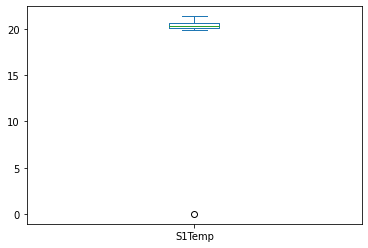

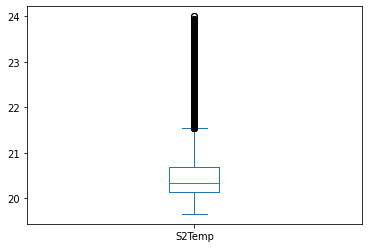

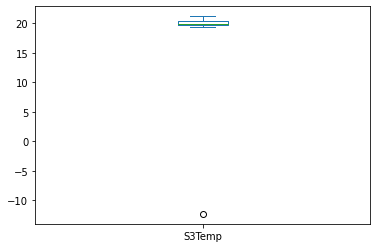

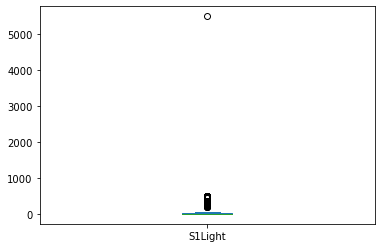

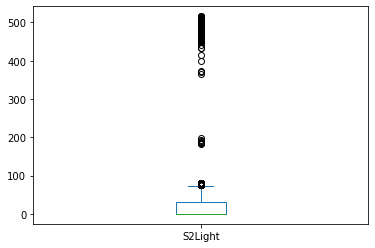

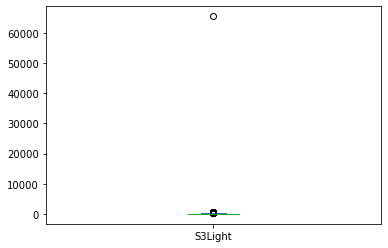

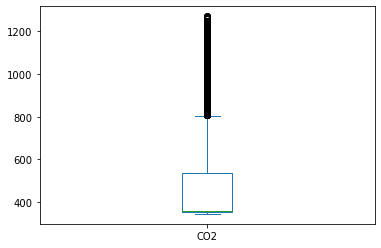

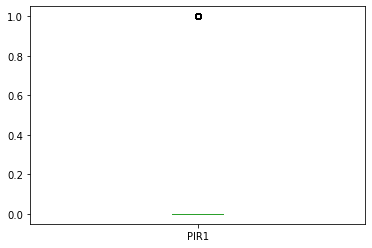

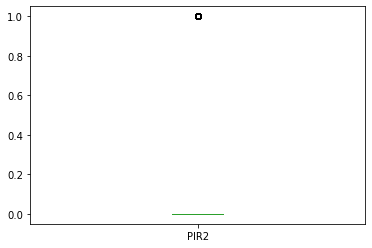

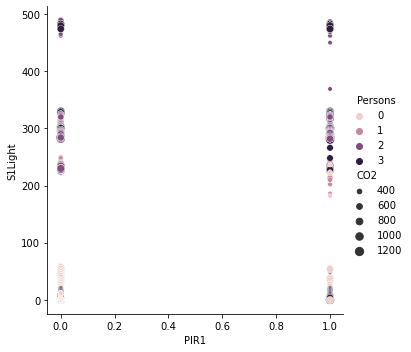

In [12]:

# Select our features that we plan to use to predict the right Species
features = ['S1Temp', 'S2Temp', 'S3Temp', 'S1Light', 'S2Light', 'S3Light', 'CO2', 'PIR1', 'PIR2']

remove_outliers(df_subset)  # removes and substitutes the outliers from the subset

scatter_plot_comparison(df_subset)  # plots scatter plot of the variables

#####  From now on the data is taken care of, so it's time to make the NN algorithm  #####


In [13]:
# In this part we test the best hyperparameters, and we calculate the scores for the predictions
neurons = round((np.sqrt(4 * 9)))

### Multiclass problem
X = df_subset.loc[:, features].copy()  # creates the variable from the features that we use to predict the output
Y = df_subset.loc[:, 'Persons'].copy()  # is the feature that we plan to predict

X_train, X_test, y_train, y_test = train_test_split(X, Y, random_state=42, train_size=.7)  # splits the data into a
# train set that we use to create the model, and a test set that we use to check the final score of the model on
# unseen data

In [14]:
scaler = MinMaxScaler()  # used to scale the data to make it usable
X_train = scaler.fit_transform(X_train)  # fits the scaler to the X_train variable and scales it
X_test = scaler.transform(X_test)  # scales the X_test with the values fitted on X_train

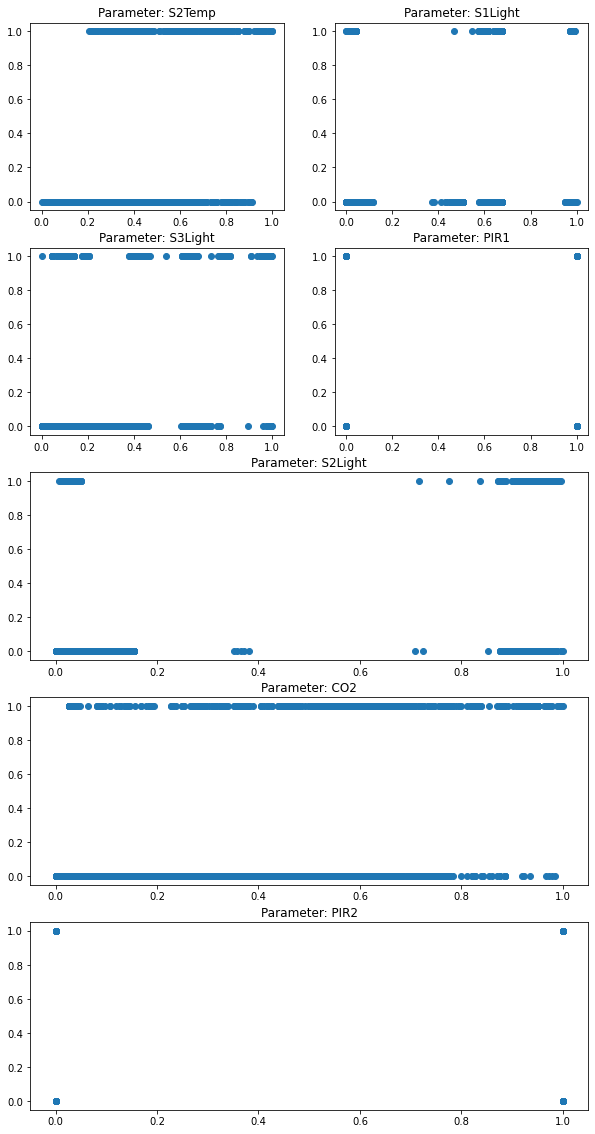

In [35]:
#####  See plots to ckeck which data is usefull after it's scaled  #####
plt.figure(figsize=(10,20))
plt.subplot(511)
plt.scatter(X_train[:,0],y_train)
plt.title('Parameter: ' + features[0])
plt.subplot(521)
plt.scatter(X_train[:,1],y_train)
plt.title('Parameter: ' + features[1])
plt.subplot(512)
plt.scatter(X_train[:,2],y_train)
plt.title('Parameter: ' + features[2])
plt.subplot(522)
plt.scatter(X_train[:,3],y_train)
plt.title('Parameter: ' + features[3])
plt.subplot(513)
plt.scatter(X_train[:,4],y_train)
plt.title('Parameter: ' + features[4])
plt.subplot(523)
plt.scatter(X_train[:,5],y_train)
plt.title('Parameter: ' + features[5])
plt.subplot(514)
plt.scatter(X_train[:,6],y_train)
plt.title('Parameter: ' + features[6])
plt.subplot(524)
plt.scatter(X_train[:,7],y_train)
plt.title('Parameter: ' + features[7])
plt.subplot(515)
plt.scatter(X_train[:,8],y_train)
plt.title('Parameter: ' + features[8])
plt.show()
plt.close()


0.9858956276445698
{'activation': 'relu', 'hidden_layer_sizes': (7, 4, 3), 'learning_rate': 'adaptive', 'max_iter': 2000, 'random_state': 4, 'solver': 'sgd'}
Counter: Counter({0: 5619, 3: 5619, 1: 5619, 2: 5619})


c:\Users\tiago\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


Score: 0.946832176543869
Best Params: {'activation': 'logistic', 'hidden_layer_sizes': (15, 9), 'learning_rate': 'constant', 'max_iter': 1000, 'random_state': 4, 'solver': 'sgd'}
NORMAL VALUES:
0.9871650211565586
Accuracy: 0.99


c:\Users\tiago\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


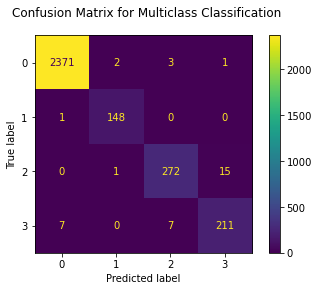

MULTI-CLASS PROBLEM SCORES: 
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2377
           1       0.98      0.99      0.99       149
           2       0.96      0.94      0.95       288
           3       0.93      0.94      0.93       225

    accuracy                           0.99      3039
   macro avg       0.97      0.97      0.97      3039
weighted avg       0.99      0.99      0.99      3039



In [16]:
# save the scaler model to disk
filename2 = 'scaler.sav'
pickle.dump(scaler, open(filename2, 'wb'))

multiclass_problem(neurons, X_train, y_train, X_test, y_test)  # function responsible to predict how many people are inside the lab

Score: 0.980818053596615
Best Params: {'activation': 'relu', 'hidden_layer_sizes': (6, 4, 4), 'learning_rate': 'constant', 'max_iter': 1000, 'random_state': 4, 'solver': 'sgd'}
NORMAL VALUES:
0.980818053596615
Accuracy: 0.98


c:\Users\tiago\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


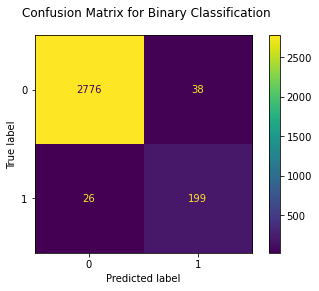

BINARY PROBLEM SCORES: 
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      2814
           1       0.84      0.88      0.86       225

    accuracy                           0.98      3039
   macro avg       0.92      0.94      0.93      3039
weighted avg       0.98      0.98      0.98      3039



In [17]:

### Binary problem
df_subset['Binary'] = df_subset['Persons'].apply(lambda x: 1 if x > 2 else 0)  # creates new column about how many
# people are inside the room. If it is 1 there are more than two people, if it's 0 there is less

X = df_subset.loc[:, features].copy()
Y = df_subset.loc[:, 'Binary'].copy()

X_train, X_test, y_train, y_test = train_test_split(X, Y, random_state=42, train_size=.7)

scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

binary_problem(neurons, X_train, y_train, X_test, y_test)   # function responsible to predict if there is more or less than 2 people inside the room
